In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def concatenate_data(imdb,amazon,yelp):
    data = []
    columns = ['sentence','label']
    path = 'sentiment labelled sentences'
    if imdb:
        data.append(pd.read_csv(os.path.join(path,'imdb_labelled.txt'), sep='\t', names=columns))
    if amazon:
        data.append(pd.read_csv(os.path.join(path,'amazon_cells_labelled.txt'), sep='\t', names = columns))
    if yelp:
        data.append(pd.read_csv(os.path.join(path,'yelp_labelled.txt'), sep='\t', names = columns))
    return pd.concat(data)
data = concatenate_data(True,True,True)
data

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [3]:
def preprocess(text_data):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    text_data['sentence'] = text_data['sentence'].apply(lambda x: tokenizer.tokenize(x.lower()))
    text_data['sentence'] = text_data['sentence'].apply(lambda x: [word for word in x if word not in stop_words])
    text_data['sentence'] = text_data['sentence'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(text_data['sentence'], text_data['label'], test_size=0.2, random_state=0)
    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test = preprocess(data)
X_train

824                                        awful service
526                     seriously worth wasting kid time
761    around years carries highest quality anti glar...
144    telephone repair man really funny reactions nu...
735                 probably never coming back recommend
                             ...                        
15                 highly recommend one blue tooth phone
87                            construction headsets poor
905        nearly good looking amazon picture makes look
859                                   worst food service
984                                 ha long bay bit flop
Name: sentence, Length: 2198, dtype: object

In [4]:
def create_bag_of_words(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf,X_test_tfidf
X_train_tfidf,X_test_tfidf = create_bag_of_words(X_train,X_test)
X_train_tfidf

<2198x4347 sparse matrix of type '<class 'numpy.float64'>'
	with 13891 stored elements in Compressed Sparse Row format>

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [6]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()

Fold: 1
Accuracy: 0.8045454545454546
Precision: 0.8333333333333334
Recall: 0.7657657657657657
F1 Score: 0.7981220657276996


Fold: 2
Accuracy: 0.7818181818181819
Precision: 0.7837837837837838
Recall: 0.7837837837837838
F1 Score: 0.7837837837837838


Fold: 3
Accuracy: 0.8204545454545454
Precision: 0.8294930875576036
Recall: 0.8108108108108109
F1 Score: 0.8200455580865603


Fold: 4
Accuracy: 0.7835990888382688
Precision: 0.8118811881188119
Recall: 0.7420814479638009
F1 Score: 0.7754137115839245


Fold: 5
Accuracy: 0.8109339407744874
Precision: 0.8165137614678899
Recall: 0.8054298642533937
F1 Score: 0.8109339407744874


Mean Metrics
Mean Accuracy: 0.8002702422861876
Mean Precision: 0.8150010308522846
Mean Recall: 0.781574334515511
Mean F1 Score: 0.7976598119912912
Best Estimator: 0
Test Metrics
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       272
           1       0.74      0.77      0.75       278

    accuracy                     

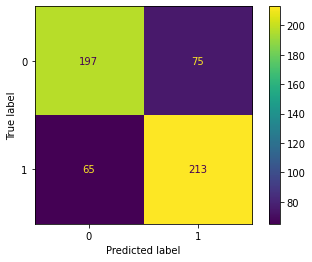

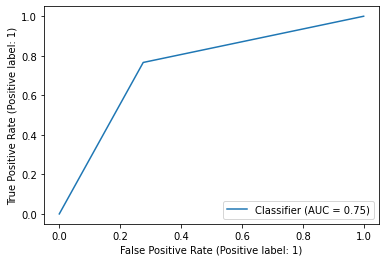

In [7]:
clf = SVC(kernel='linear')
best_estimator = cross_validate_and_train(clf,X_train_tfidf,y_train)
test_model(best_estimator,X_test_tfidf,y_test)

Fold: 1
Accuracy: 0.7386363636363636
Precision: 0.8322981366459627
Recall: 0.6036036036036037
F1 Score: 0.6997389033942559


Fold: 2
Accuracy: 0.7454545454545455
Precision: 0.8055555555555556
Recall: 0.6531531531531531
F1 Score: 0.7213930348258707


Fold: 3
Accuracy: 0.7818181818181819
Precision: 0.7647058823529411
Recall: 0.8198198198198198
F1 Score: 0.7913043478260868


Fold: 4
Accuracy: 0.7061503416856492
Precision: 0.7555555555555555
Recall: 0.6153846153846154
F1 Score: 0.6783042394014963


Fold: 5
Accuracy: 0.7425968109339408
Precision: 0.7783505154639175
Recall: 0.6832579185520362
F1 Score: 0.7277108433734939


Mean Metrics
Mean Accuracy: 0.7429312487057362
Mean Precision: 0.7872931291147864
Mean Recall: 0.6750438221026457
Mean F1 Score: 0.7236902737642408
Best Estimator: 0
Test Metrics
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       272
           1       0.76      0.60      0.67       278

    accuracy                    

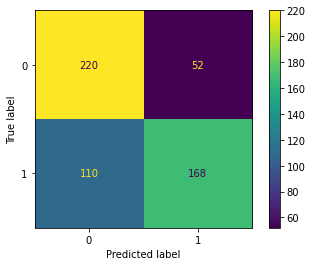

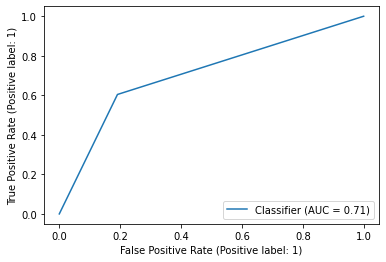

In [8]:
clf = KNeighborsClassifier(n_neighbors=5)
best_estimator = cross_validate_and_train(clf,X_train_tfidf,y_train)
test_model(best_estimator,X_test_tfidf,y_test)

Fold: 1
Accuracy: 0.6568181818181819
Precision: 0.628158844765343
Recall: 0.7837837837837838
F1 Score: 0.6973947895791583


Fold: 2
Accuracy: 0.6818181818181818
Precision: 0.7135416666666666
Recall: 0.6171171171171171
F1 Score: 0.6618357487922705


Fold: 3
Accuracy: 0.7136363636363636
Precision: 0.6764705882352942
Recall: 0.8288288288288288
F1 Score: 0.7449392712550607


Fold: 4
Accuracy: 0.6355353075170843
Precision: 0.6150943396226415
Recall: 0.7375565610859729
F1 Score: 0.6707818930041152


Fold: 5
Accuracy: 0.7107061503416856
Precision: 0.7238095238095238
Recall: 0.6877828054298643
F1 Score: 0.7053364269141532


Mean Metrics
Mean Accuracy: 0.6797028370262994
Mean Precision: 0.6714149926198938
Mean Recall: 0.7310138192491135
Mean F1 Score: 0.6960576259089517
Best Estimator: 2
Test Metrics
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       272
           1       0.66      0.76      0.70       278

    accuracy                     

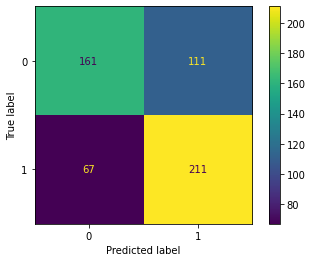

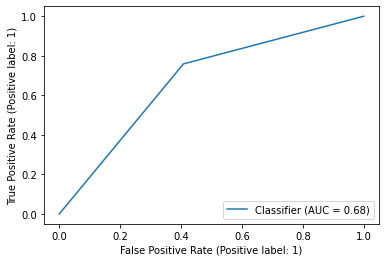

In [10]:
clf = GaussianNB()
best_estimator = cross_validate_and_train(clf,X_train_tfidf.toarray(),y_train)
test_model(best_estimator,X_test_tfidf.toarray(),y_test)

Fold: 1
Accuracy: 0.7454545454545455
Precision: 0.7722772277227723
Recall: 0.7027027027027027
F1 Score: 0.7358490566037735


Fold: 2
Accuracy: 0.7204545454545455
Precision: 0.7323943661971831
Recall: 0.7027027027027027
F1 Score: 0.7172413793103449


Fold: 3
Accuracy: 0.7522727272727273
Precision: 0.748898678414097
Recall: 0.7657657657657657
F1 Score: 0.757238307349666


Fold: 4
Accuracy: 0.7585421412300684
Precision: 0.8042328042328042
Recall: 0.6877828054298643
F1 Score: 0.7414634146341463


Fold: 5
Accuracy: 0.7995444191343963
Precision: 0.821256038647343
Recall: 0.7692307692307693
F1 Score: 0.7943925233644861


Mean Metrics
Mean Accuracy: 0.7552536757092566
Mean Precision: 0.7758118230428399
Mean Recall: 0.7256369491663609
Mean F1 Score: 0.7492369362524833
Best Estimator: 4
Test Metrics
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       272
           1       0.72      0.72      0.72       278

    accuracy                       

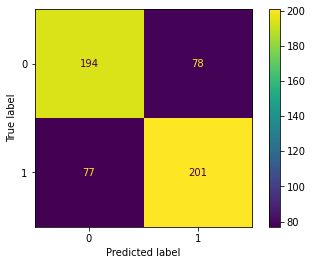

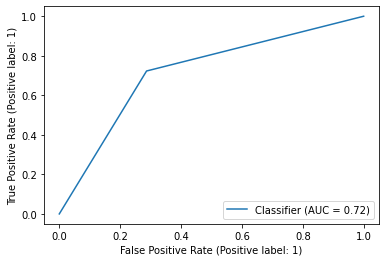

In [11]:
clf = DecisionTreeClassifier()
best_estimator = cross_validate_and_train(clf,X_train_tfidf,y_train)
test_model(best_estimator,X_test_tfidf,y_test)